### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
import joblib

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


### Preparing data

#### Functions

In [9]:
# Função de seleção
def tag_first_last(df) -> pd.DataFrame:
    final_df = pd.DataFrame()

    d0 = df[df['RESULTADO'] == 0]
    d1 = df[df['RESULTADO'] == 1]

    # grouped = d0.groupby(by=['ID_AMOSTRA','TAG'])
    # first_last = grouped.apply(lambda x: x.iloc[[0,-1]]).reset_index(drop=True)
    # final_df = pd.concat([first_last, d1])
    # return final_df

    d0_sorted = d0.sort_values(by=['ID_AMOSTRA','TAG','instant'])
    d0_grouped = d0_sorted.groupby(by=['ID_AMOSTRA','TAG'])
    first_last = d0_grouped.apply(lambda x: x.iloc[[0,-1]]).reset_index(drop=True).drop_duplicates()
    final_df = pd.concat([first_last, d1])
    return final_df

# Funções de transformação
def remove_invalid_tipo(df) -> pd.DataFrame:
    df = df.loc[df['TIPO'] != -1]
    return df

def add_datetime_and_sort(df) -> pd.DataFrame:
    df['DT'] = pd.to_datetime(df["TIMESTAMP"], unit='ms')
    df = df.sort_values(by='DT')
    return df

def add_instant_in_df(df) -> pd.DataFrame:
    df['min_dt'] = df.groupby('ID_AMOSTRA')['DT'].transform('min')
    df['instant'] = (df['DT'] - df['min_dt']).dt.total_seconds()
    df.drop(columns=['min_dt'], inplace=True)
    return df

def add_tags_count_in_df(df) -> pd.DataFrame:
    df['tag_count_inside_id_amostra'] = df.groupby(['ID_AMOSTRA', 'TAG'])['TAG'].transform('count')
    return df

def add_velocity(df):
    
    # Passo 1: Ordenar os dados por ID_AMOSTRA, TAG, ANTENA e instant
    df = df.sort_values(by=['ID_AMOSTRA', 'TAG', 'ANTENA', 'instant'])
    
    # Passo 2: Calcular a diferença de RSSI entre leituras consecutivas para cada TAG em um ID_AMOSTRA e ANTENA
    df['velocity'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['instant'].diff()
    

    # Passo 5: Preencher NaN com 0 para as primeiras leituras (sem leituras anteriores para comparação)
    df['velocity'] = df['velocity'].fillna(0)
    
    # Retornar o DataFrame com a nova coluna 'velocity'
    return df

def calculate_tipo_measurements(df):
    df = df.sort_values(by=['ID_AMOSTRA', 'TAG', 'TIPO', 'instant'])

    # Usando transform para manter o índice original
    df['first_rssi_tipo'] = df.groupby(['ID_AMOSTRA', 'TAG', 'TIPO'])['RSSI'].transform('first')
    df['last_rssi_tipo'] = df.groupby(['ID_AMOSTRA', 'TAG', 'TIPO'])['RSSI'].transform('last')
    df['mean_rssi_tipo'] = df.groupby(['ID_AMOSTRA', 'TAG', 'TIPO'])['RSSI'].transform('mean')
    df['len_rssi_tipo'] = df.groupby(['ID_AMOSTRA', 'TAG', 'TIPO'])['RSSI'].transform('count')
    
    return df 

def calculate_movement(df):
    df = df.sort_values(by=['ID_AMOSTRA', 'TAG', 'ANTENA', 'instant'])

    # Usando transform para manter o índice original
    df['first_rssi_antena'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['RSSI'].transform('first')
    df['last_rssi_antena'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['RSSI'].transform('last')
    df['mean_rssi_antena'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['RSSI'].transform('mean')
    df['len_rssi_antena'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['RSSI'].transform('count')

    # Função para determinar o movimento
    def determine_movement(row):
        if row['len_rssi_antena'] == 1:
            return 'indeciso'
        elif row['first_rssi_antena'] < row['mean_rssi_antena'] < row['last_rssi_antena']:
            return 'aproximando'
        elif row['first_rssi_antena'] > row['mean_rssi_antena'] > row['last_rssi_antena']:
            return 'afastando'
        else:
            return 'indefinido'  # Para casos que não se enquadram nas condições acima

    # Aplicando a função para criar a nova coluna 'movement'
    df['movement'] = df.apply(determine_movement, axis=1)
    
    return df 

def calculate_tipo_antena(df):
    df = df.sort_values(by=['ID_AMOSTRA', 'TAG', 'ANTENA','TIPO', 'instant'])
    df['count_tipo_antena'] = df.groupby(['ID_AMOSTRA', 'TAG', 'ANTENA'])['TIPO'].transform('count')
    
    return df 


# Funções de categorização com bins parametrizados
def add_categorize_instant(df, bins=None) -> pd.DataFrame:
    if bins is None:
        df['instant_categoria'], bins = pd.qcut(df['instant'], q=5, labels=['Início','Meio-Início','Meio','Meio-Final','Final'], retbins=True)
    else:
        df['instant_categoria'] = pd.cut(df['instant'], bins=bins, labels=['Início','Meio-Início','Meio','Meio-Final','Final'])
    return df, bins

def add_tag_duration_categorize(df, bins=None) -> pd.DataFrame:
    df = df.sort_values(by=['ID_AMOSTRA', 'TAG', 'instant'])
    df['tag_duration'] = df.groupby(['ID_AMOSTRA', 'TAG'])['instant'].transform(lambda x: x.max() - x.min())

    if bins is None:
        df['tag_duration_categoria'], bins = pd.qcut(df['tag_duration'], q=6, duplicates='drop', retbins=True)
    else:
        df['tag_duration_categoria'] = pd.cut(df['tag_duration'], bins=bins)

    df = df.drop(['tag_duration'], axis=1)
    return df, bins

def add_velocity_categorize(df,bins=None) -> pd.DataFrame:
    if bins is None:
        df['velocity_categoria'], bins = pd.qcut(df['velocity'], q=4, duplicates='drop', retbins=True)
    else:
        df['velocity_categoria'] = pd.cut(df['velocity'], bins=bins)
    return df, bins


#### Applying transforms

In [5]:
# Função para aplicar as transformações com retorno dos parâmetros globais
def apply_transforms_df(df, transforms_df):
    df_final = df.copy()
    params = {}  # Dicionário para armazenar os parâmetros globais (bins)
    
    for func in transforms_df:
        if func.__name__ in ['add_categorize_instant', 'add_tag_count_categorize', 'add_tag_duration_categorize','add_velocity_categorize']:
            df_final, bins = func(df_final)  # A função retorna o dataframe transformado e os bins
            params[func.__name__] = bins  # Salva os bins
        else:
            df_final = func(df_final)  # Funções que não retornam bins
    return df_final, params

# Função para aplicar as transformações em df2 reutilizando os parâmetros de df1
def apply_transforms_with_params(df, transforms_df, params):
    df_final = df.copy()
    
    for func in transforms_df:
        if func.__name__ in ['add_categorize_instant', 'add_categorize_rssi', 'add_categorize_p1','add_categorize_p2','add_categorize_p3','add_categorize_p4', 'add_tag_count_categorize', 'add_tag_duration_categorize','add_velocity_categorize']:
            df_final, _ = func(df_final, bins=params[func.__name__])  # Reutiliza os bins de df1
        else:
            df_final = func(df_final)  # Funções que não dependem de bins
    return df_final

# Lista de transformações
transforms_df = [
    remove_invalid_tipo,
    add_datetime_and_sort,
    add_instant_in_df,

    add_tags_count_in_df,
    add_velocity,
    
    add_categorize_instant,
    add_tag_duration_categorize,
    add_velocity_categorize,

    calculate_movement, 
    calculate_tipo_measurements,
    calculate_tipo_antena
]

# Carregar os dados
df1 = pd.read_csv('amostra_02.csv')
df2 = pd.read_csv('amostra_03.csv')

# Aplicar as transformações em df1 e obter os parâmetros globais
df1, params = apply_transforms_df(df1, transforms_df)

# Aplicar as transformações em df2 reutilizando os parâmetros de df1
df2 = apply_transforms_with_params(df2, transforms_df, params)

# df1 e df2 agora estão transformados de maneira consistente

df1

,ID_AMOSTRA,TIMESTAMP,TIPO,ANTENA,RSSI,TAG,RESULTADO,DT,instant,tag_count_inside_id_amostra,velocity,instant_categoria,tag_duration_categoria,velocity_categoria,first_rssi_antena,last_rssi_antena,mean_rssi_antena,len_rssi_antena,movement,first_rssi_tipo,last_rssi_tipo,mean_rssi_tipo,len_rssi_tipo,count_tipo_antena
263,2323,1715271503114,0,1,-66,E2801170000002139020CB0A,0,2024-05-09 16:18:23.114,0.686,2,0.000,Meio,"(-0.001, 1.277]","(-0.001, 0.837]",-66,-66,-66.000000,1,indeciso,-77,-66,-71.500000,2,1
91,2323,1715271502479,0,4,-77,E2801170000002139020CB0A,0,2024-05-09 16:18:22.479,0.051,2,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-77,-77,-77.000000,1,indeciso,-77,-66,-71.500000,2,1
69,2323,1715271502467,0,4,-70,E28011700000021390210D5B,0,2024-05-09 16:18:22.467,0.039,1,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-70,-70,-70.000000,1,indeciso,-70,-70,-70.000000,1,1
134,2323,1715271502501,0,2,-77,E2801170000002139021725D,0,2024-05-09 16:18:22.501,0.073,3,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-77,-76,-75.666667,3,indefinido,-77,-76,-75.666667,3,3
226,2323,1715271502631,0,2,-74,E2801170000002139021725D,0,2024-05-09 16:18:22.631,0.203,3,0.130,Meio-Início,"(-0.001, 1.277]","(-0.001, 0.837]",-77,-76,-75.666667,3,indefinido,-77,-76,-75.666667,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123509,888783,1715265638863,0,1,-64,E28069950000500EDEA6902F,0,2024-05-09 14:40:38.863,0.625,3,0.556,Meio,"(2.598, 3.29]","(-0.001, 0.837]",-60,-56,-60.000000,3,indefinido,-60,-64,-62.000000,2,3
123741,888783,1715265641294,1,1,-56,E28069950000500EDEA6902F,0,2024-05-09 14:40:41.294,3.056,3,2.431,Final,"(2.598, 3.29]","(0.837, 50.35]",-60,-56,-60.000000,3,indefinido,-56,-56,-56.000000,1,3
123436,888783,1715265638364,0,1,-70,E28069950000500EDEA86D4A,0,2024-05-09 14:40:38.364,0.126,2,0.000,Início,"(3.29, 4.193]","(-0.001, 0.837]",-70,-72,-71.000000,2,afastando,-70,-70,-70.000000,1,2
123793,888783,1715265641980,2,1,-72,E28069950000500EDEA86D4A,0,2024-05-09 14:40:41.980,3.742,2,3.616,Final,"(3.29, 4.193]","(0.837, 50.35]",-70,-72,-71.000000,2,afastando,-72,-72,-72.000000,1,2


### Functions

In [6]:
def plot_feature_importance(model, feature_names):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Gráfico de Importância das Features
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

### Pre-processing

In [7]:
def preprocess_data(df, preprocessor=None):
    # Remover colunas irrelevantes
    df = df.drop(columns=['ID_AMOSTRA', 'TIMESTAMP', 'DT'])  # num cols
    df = df.drop(columns=['TIPO','TAG'])  # cat cols

    # Separar características (X) e rótulo (y)
    X = df.drop(columns=['RESULTADO'])
    y = df['RESULTADO']

    numeric_features = ['instant','RSSI','velocity','tag_count_inside_id_amostra', 'first_rssi_antena', 'last_rssi_antena', 'mean_rssi_antena', 'len_rssi_antena', 'first_rssi_tipo', 'mean_rssi_tipo', 'last_rssi_tipo', 'len_rssi_tipo','count_tipo_antena']
    categorical_features = ['instant_categoria', 'movement','tag_duration_categoria','ANTENA', 'velocity_categoria']

    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
            ])
        X_processed = preprocessor.fit_transform(X)
    else:
        X_processed = preprocessor.transform(X)

    return X_processed, y, preprocessor





### Train and evaluate function

In [8]:
def train_and_evaluate(df, df2):
    X, y, preprocessor = preprocess_data(df)
    X_test, y_test = preprocess_data(df2, preprocessor)[0:2]
    
    skfold = StratifiedKFold(n_splits=5, shuffle=True)
    
    best_f1 = 0
    best_model = None

    for fold, (train_index, val_index) in enumerate(skfold.split(X, y)):
        print(f"Processing Fold {fold + 1}\n")
        
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Aplicar SMOTE apenas no conjunto de treino
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # model = CatBoostClassifier(verbose=1, iterations=2000, depth=6, learning_rate=0.1)
        model = CatBoostClassifier(
                iterations=2000,             # Mantendo um número alto para ajuste fino
                learning_rate=0.05,         # Levemente aumentado para acelerar o aprendizado
                depth=6,                     # Reduzir a profundidade para evitar overfitting
                #scale_pos_weight=4,          # Aumentar o peso da classe minoritária
                loss_function='Logloss',     # Usando a função de perda para classificação binária
                l2_leaf_reg=2,               # Maior regularização L2 para melhorar a generalização
                subsample=0.8,               # Mantém a subamostragem para evitar overfitting
                colsample_bylevel=0.8,       # Mantém a subamostragem de colunas para evitar overfitting
                verbose=100                  # Mantém o log para monitoramento
            )

        model.fit(X_train_resampled, y_train_resampled)

        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)
        print(f"Fold {fold + 1} - F1-Score: {f1}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = model
    
    joblib.dump(best_model, 'best_model.pkl')

    # Obter os nomes das features após transformação
    feature_names = list(preprocessor.get_feature_names_out())
    
    # Plotar a importância das features
    plot_feature_importance(best_model, feature_names)

    # Avaliar no conjunto de teste
    y_test_pred = best_model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'])
    plt.yticks(tick_marks, ['0', '1'])

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.show()

#### Save modified dataframes

In [10]:
df_clean = df1.copy()
df_clean2 = df2.copy()

print(f'len(df_clean2) before: {len(df_clean2)}')

df_clean = tag_first_last(df_clean)
df_clean2 = tag_first_last(df_clean2)

print(f'len(df_clean2) after: {len(df_clean2)}')

df_clean.to_csv('df_clean.csv', index=False)
df_clean2.to_csv('df_clean2.csv', index=False)

df_clean

len(df_clean2) before: 84746


C:\Users\lucas\AppData\Local\Temp\ipykernel_16536\3673077800.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_last = d0_grouped.apply(lambda x: x.iloc[[0,-1]]).reset_index(drop=True).drop_duplicates()
C:\Users\lucas\AppData\Local\Temp\ipykernel_16536\3673077800.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_last = d0_grouped.apply(lambda x: x.iloc[[0,-1]]).reset_index(drop=True).drop_d

len(df_clean2) after: 61057


,ID_AMOSTRA,TIMESTAMP,TIPO,ANTENA,RSSI,TAG,RESULTADO,DT,instant,tag_count_inside_id_amostra,velocity,instant_categoria,tag_duration_categoria,velocity_categoria,first_rssi_antena,last_rssi_antena,mean_rssi_antena,len_rssi_antena,movement,first_rssi_tipo,last_rssi_tipo,mean_rssi_tipo,len_rssi_tipo,count_tipo_antena
0,2323,1715271502479,0,4,-77,E2801170000002139020CB0A,0,2024-05-09 16:18:22.479,0.051,2,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-77,-77,-77.000000,1,indeciso,-77,-66,-71.500000,2,1
1,2323,1715271503114,0,1,-66,E2801170000002139020CB0A,0,2024-05-09 16:18:23.114,0.686,2,0.000,Meio,"(-0.001, 1.277]","(-0.001, 0.837]",-66,-66,-66.000000,1,indeciso,-77,-66,-71.500000,2,1
2,2323,1715271502467,0,4,-70,E28011700000021390210D5B,0,2024-05-09 16:18:22.467,0.039,1,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-70,-70,-70.000000,1,indeciso,-70,-70,-70.000000,1,1
4,2323,1715271502501,0,2,-77,E2801170000002139021725D,0,2024-05-09 16:18:22.501,0.073,3,0.000,Início,"(-0.001, 1.277]","(-0.001, 0.837]",-77,-76,-75.666667,3,indefinido,-77,-76,-75.666667,3,3
5,2323,1715271503734,0,2,-76,E2801170000002139021725D,0,2024-05-09 16:18:23.734,1.306,3,1.103,Meio,"(-0.001, 1.277]","(0.837, 50.35]",-77,-76,-75.666667,3,indefinido,-77,-76,-75.666667,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123484,888783,1715265638610,0,4,-69,E28068910000500DADD29131,1,2024-05-09 14:40:38.610,0.372,11,0.000,Meio,"(3.29, 4.193]","(-0.001, 0.837]",-69,-58,-63.750000,4,aproximando,-63,-62,-65.000000,6,4
123656,888783,1715265640385,1,4,-66,E28068910000500DADD29131,1,2024-05-09 14:40:40.385,2.147,11,1.775,Meio-Final,"(3.29, 4.193]","(0.837, 50.35]",-69,-58,-63.750000,4,aproximando,-67,-58,-63.800000,5,4
123724,888783,1715265641103,1,4,-62,E28068910000500DADD29131,1,2024-05-09 14:40:41.103,2.865,11,0.718,Meio-Final,"(3.29, 4.193]","(-0.001, 0.837]",-69,-58,-63.750000,4,aproximando,-67,-58,-63.800000,5,4
123772,888783,1715265641756,1,4,-58,E28068910000500DADD29131,1,2024-05-09 14:40:41.756,3.518,11,0.653,Final,"(3.29, 4.193]","(-0.001, 0.837]",-69,-58,-63.750000,4,aproximando,-67,-58,-63.800000,5,4


### Training and evaluation

Processing Fold 1

0:	learn: 0.6060039	total: 189ms	remaining: 6m 16s
100:	learn: 0.0393090	total: 3.56s	remaining: 1m 6s
200:	learn: 0.0219920	total: 6.76s	remaining: 1m
300:	learn: 0.0153136	total: 9.85s	remaining: 55.6s
400:	learn: 0.0116259	total: 12.8s	remaining: 51.1s
500:	learn: 0.0095347	total: 15.6s	remaining: 46.6s
600:	learn: 0.0081678	total: 18.3s	remaining: 42.7s
700:	learn: 0.0072077	total: 21.1s	remaining: 39s
800:	learn: 0.0063928	total: 23.8s	remaining: 35.7s
900:	learn: 0.0059569	total: 26.4s	remaining: 32.2s
1000:	learn: 0.0055613	total: 28.9s	remaining: 28.9s
1100:	learn: 0.0053364	total: 31.4s	remaining: 25.6s
1200:	learn: 0.0051738	total: 33.8s	remaining: 22.5s
1300:	learn: 0.0050833	total: 36.2s	remaining: 19.4s
1400:	learn: 0.0048662	total: 38.6s	remaining: 16.5s
1500:	learn: 0.0046413	total: 41.2s	remaining: 13.7s
1600:	learn: 0.0045560	total: 43.9s	remaining: 10.9s
1700:	learn: 0.0044962	total: 46.6s	remaining: 8.19s
1800:	learn: 0.0044348	total: 48.9s	remaini

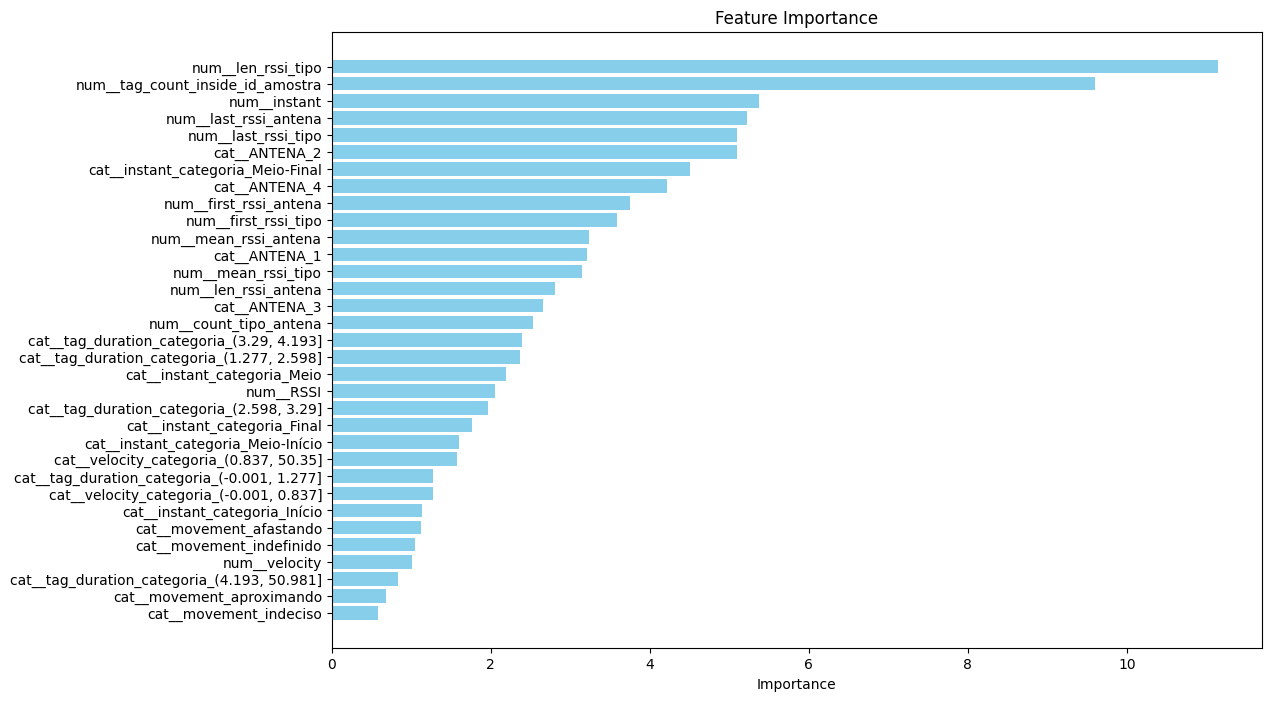

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59160
           1       0.95      0.86      0.91      1897

    accuracy                           0.99     61057
   macro avg       0.97      0.93      0.95     61057
weighted avg       0.99      0.99      0.99     61057



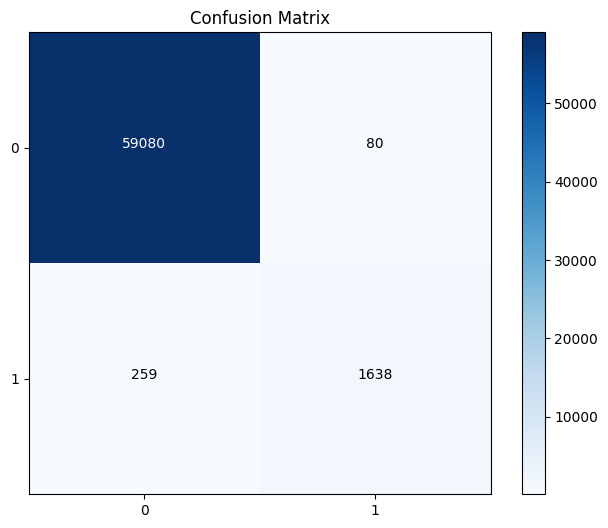

In [11]:
df = pd.read_csv('df_clean.csv')
df2 = pd.read_csv('df_clean2.csv')

train_and_evaluate(df,df2)